In [1]:
# importing moudles
# and using some magic to autoreload them if changed
%load_ext autoreload
%autoreload 2

import sys

sys.path.append('../nonlin')
sys.path.append('../partion')
sys.path.append('../1D-difusion')

from aspen import aspen
from newton import newton

import partion
from partion import metrics1, metrics2, m1, m2, m3
import wrapper

from one_phase import one_phase
import numpy as np
import matplotlib.pyplot as plt

test = wrapper.test_decorator(wrapper.test)

### Построение доменов по параметрам диффузии

In [2]:
# model to be considered
# we will vary only permability parameter
def model(u):
    return np.array([u**2+1, 2*max(u, 0)])

class Diffusion():
    def __init__(self, Nx, Amp=0, Period=0, Scale=1, model=None):
        self.val = np.zeros((Nx+1, 1))
        for i in range(Nx+1):
            self.val[i] = (
                Amp * np.sin(Period * 2*np.pi * (i+1) / (Nx+1)) + 1) * Scale
        self.model = model

Мы будем рассматривать следующий класс задач: зафиксированные границы (0, 1), начальное условие - прямая $u = x$, пронциаемость среды модулируем случайными синусоидами

In [3]:
Nx = 500
Nt = 50
D = Diffusion(Nx, model=model)
bd1 = 0
bd2 = 1
x0 = np.arange(Nx)/(Nx-1)
x0 = np.reshape(x0, (-1, 1))

Мы будем строить домены по экстремумам пронциаемости среды, ожидается что на участках с разной производной будет разная динамика потоков

In [4]:
def borders_df(D):
    bd_df = [0]
    for i in range(1, Nx):
        if(np.sign(D.val[i]-D.val[i-1])*np.sign(D.val[i+1]-D.val[i]) < 0 ):
            bd_df.append(i)
    bd_df.append(Nx)
    return bd_df

In [5]:
param = {
    'Nx': Nx, 
    'Nt': Nt,
}

N = 10
t_new = np.zeros(N)
t_as = np.zeros(N)
t_eq = np.zeros(N)
for i in range(N):
    # permebility distribuition
    D.val = np.zeros((Nx+1, 1))
    for k in range(5):
        T = np.random.randint(1, 5)
        amp = np.random.random()
        D.val += amp*np.sin(T * 2*np.pi * np.linspace(0, 1, Nx+1)).reshape(-1, 1)
    D.val /= np.max(np.abs(D.val))+1e-2
    D.val = 1 + D.val
    '''
    plt.plot(D.val)
    plt.show()
    '''
    
    nl_solver = newton(1e-2, kmax = 14, crit_abs = 1e-3)
    solver_cl = one_phase(param, D, nl_solver)
    solver_cl.x0 = np.copy(x0)
    solver_cl.setBoundary(bd1, bd2)
    _, _, _, t = wrapper.test(solver_cl, sample_size = 3)
    t_new[i] = t
    
    part = borders_df(D)
    Nd = len(part)-1
    nl_solver = aspen(Nd, part, 1e-2, crit_abs = 1e-3)
    solver_as = one_phase(param, D, nl_solver)
    solver_as.x0 = np.copy(x0)
    solver_as.setBoundary(bd1, bd2)
    _, _, _, t = wrapper.test(solver_cl, sample_size = 3)
    t_as[i] = t
    
    Nd = 5
    part = partion.partion_equally(Nx, Nd)
    nl_solver = aspen(Nd, part, 1e-2, crit_abs = 1e-3)
    solver_as = one_phase(param, D, nl_solver)
    solver_as.x0 = np.copy(x0)
    solver_as.setBoundary(bd1, bd2)
    _, _, _, t = wrapper.test(solver_cl, sample_size = 3)
    t_eq[i] = t
    

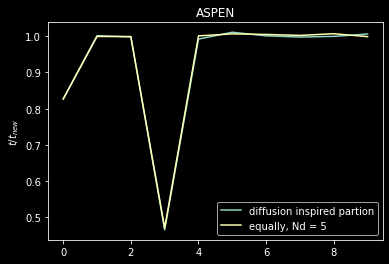

In [6]:
plt.style.use('dark_background')
plt.title('ASPEN')
plt.plot(t_as/t_new, label='diffusion inspired partion')
plt.plot(t_eq/t_new, label='equally, Nd = 5')
plt.ylabel('$t$/$t_{new}$')
plt.legend()
plt.savefig('./data/diff_part', dpi = 400)
plt.show()

### Построение доменов через разбиение графа
Две формулировки функции на минимизацию:
$$
    vol(\partial S_i) = \sum_{v \in V_i} \sum_{u \in \Gamma(v), u \notin V_i} {w(v, u)}
$$
Первый способ:$$
\sum \frac{vol(\partial S_i)}{| V_i|} \rightarrow \min
$$Второй способ:$$
\sum \frac{vol(\partial S_i)}{vol(V_i)} \rightarrow \min
$$где $vol(V_i) = \sum_{u, v \in V_i} w(u, v)$

## Задача 1
Сперва рассмотрим задачу с фиксированными концами (0, 1), для которой известны начальные условия и параметры диффузии. Сравним между собой метрики на ней

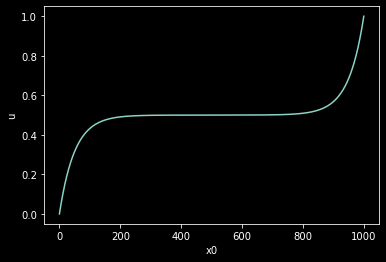

In [7]:
# inital condition
Nx = 1000
Nt = 100
D = Diffusion(Nx, 0.9, 1, 0.5e-1, model=model)
bd1 = 0
bd2 = 1
x0 = np.arange(Nx)/(Nx-1)
x0 = np.sinh(20*(x0-0.5))
x0 /= np.max(x0)
x0 = (x0+1)/2
x0 = np.reshape(x0, (-1, 1))
plt.xlabel('x0')
plt.ylabel('u')
plt.plot(x0)

In [8]:
param = {
    'Nx': Nx, 
    'Nt': Nt,
}
nl_solver = newton(1e-2, kmax = 14, crit_abs = 1e-3)
solver_cl = one_phase(param, D, nl_solver)
solver_cl.x0 = np.copy(x0)
solver_cl.setBoundary(bd1, bd2)
X_cl, message, t_new = test(solver_cl, sample_size = 5)

test started
verdict : OK
mean time : 53.46961526870727
mean newton iterations:  4.11


In [9]:
# we will store resuts there
results1 = {}

In [10]:
A1 = np.zeros((Nx, Nx))
A2 = np.zeros((Nx, Nx))
A3 = np.zeros((Nx, Nx))
M = 5
du = 1e-2
for i in range(M):
    step = Nt//M
    Jf = partion.precompute_Jf(solver_cl, X_cl[:, i*step], Nx)
    Jf_n = partion.precompute_Jf(solver_cl, X_cl[:, i*step]+du, Nx)
    f1 = lambda k, m: m1(Jf, k, m)
    f3 = lambda k, m: m3(solver_cl, Jf, Jf_n, k, m)
    B = partion.adj_matrix(f1, Nx)
    B /= np.max(B)
    A1 += B
    B = partion.adj_matrix(f3, Nx)
    B /= np.max(B)
    A3 += B
f2 = lambda k, m: m2(X_cl, k, m)
A2 = partion.adj_matrix(f2, Nx)
A1 /= M
A3 /= M

In [11]:
Nd = 4
results1['bd_m1'] = partion.domain_builder2(A1, Nd, inv = False, k = Nd)
results1['bd_m2'] = partion.domain_builder2(A2, Nd, inv = True, k = Nd)
results1['bd_m3'] = partion.domain_builder2(A3, Nd, inv = False, k = Nd)

for bd, A, metrics in zip([results1['bd_m1'], results1['bd_m2'],
    results1['bd_m3']], [A1, A2, A3], [partion.metrics1, partion.metrics2, partion.metrics1]):
    print(bd)
    print('eq : {}'.format(metrics(
    partion.partion_equally(Nx, Nd), A)))
    print('spec : {}'.format(metrics(
    bd, A)))

[   0  156  341  583 1000]
eq : 0.004668239795785708
spec : 0.0016018526496152162
[   0  204  498  792 1000]
eq : 0.0030092651147689844
spec : 0.0029352606896291336
[   0  141  403  699 1000]
eq : 4.5185649354472694e-05
spec : 4.614494315061673e-05


test started
verdict : OK
mean time : 40.02464165687561
mean aspen iterations:  1.07
iters : [6.63 1.07 1.   1.08]


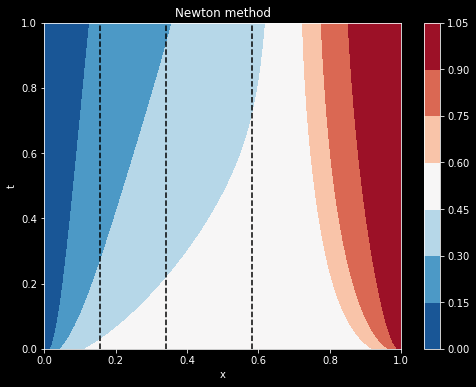

In [12]:
borders = results1['bd_m1']

Nd = 4
param = {
    'Nx': Nx, 
    'Nt': Nt
}
nl_solver = aspen(Nd, borders, 1e-2, crit_abs = 1e-3)
solver_as = one_phase(param, D, nl_solver)
solver_as.x0 = np.copy(x0)
solver_as.setBoundary(bd1, bd2)
X, message, t = test(solver_as, sample_size = 5)
results1['t_m1'] = np.copy(t)
wrapper.show_res(solver_as)

test started
verdict : OK
mean time : 40.114402294158936
mean aspen iterations:  1.0
iters : [6.11 1.   1.   1.01]


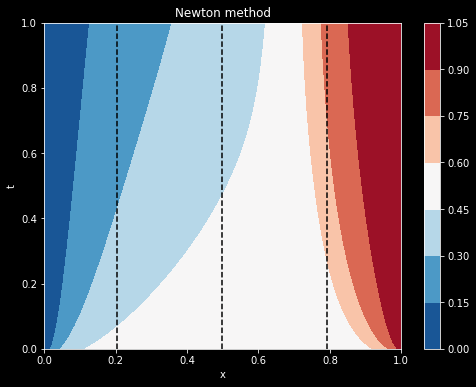

In [13]:
borders = results1['bd_m2']

Nd = 4
param = {
    'Nx': Nx, 
    'Nt': Nt
}
nl_solver = aspen(Nd, borders, 1e-2, crit_abs = 1e-3)
solver_as = one_phase(param, D, nl_solver)
solver_as.x0 = np.copy(x0)
solver_as.setBoundary(bd1, bd2)
X, message, t = test(solver_as, sample_size = 5)
results1['t_m2'] = np.copy(t)
wrapper.show_res(solver_as)

test started
verdict : OK
mean time : 39.60097517967224
mean aspen iterations:  1.11
iters : [7.15 1.11 1.   1.11]


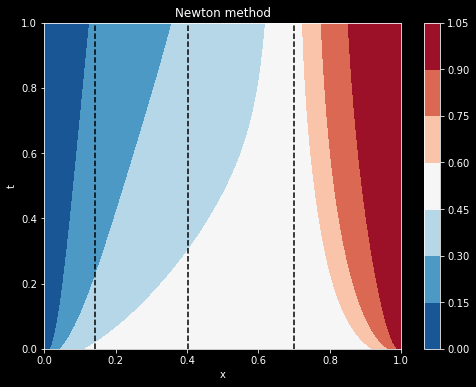

--time comparision--
newton : 53.37339639663696
aspen : 39.41335678100586


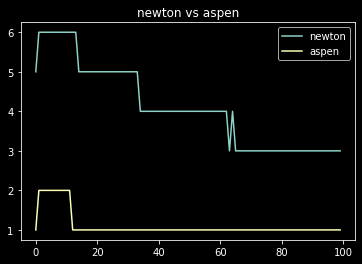

In [14]:
borders = results1['bd_m3']

Nd = 4
param = {
    'Nx': Nx, 
    'Nt': Nt
}
nl_solver = aspen(Nd, borders, 1e-2, crit_abs = 1e-3)
solver_as = one_phase(param, D, nl_solver)
solver_as.x0 = np.copy(x0)
solver_as.setBoundary(bd1, bd2)
X, message, t = test(solver_as, sample_size = 5)
results1['t_m3'] = np.copy(t)
wrapper.show_res(solver_as, save = './data/m3_Nd4')
wrapper.compare([solver_cl, solver_as], ['newton', 'aspen'], save = './data/m3_comp_Nd4')

test started
verdict : OK
mean time : 42.26943402290344
mean aspen iterations:  1.0
iters : [6.09 1.   1.   1.01]


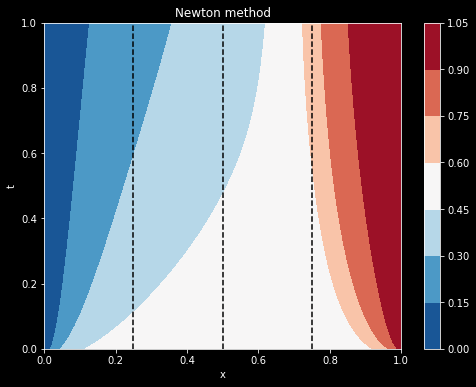

In [15]:
borders = partion.partion_equally(Nx, Nd)

Nd = 4
param = {
    'Nx': Nx, 
    'Nt': Nt
}
nl_solver = aspen(Nd, borders, 1e-2, crit_abs = 1e-3)
solver_as = one_phase(param, D, nl_solver)
solver_as.x0 = np.copy(x0)
solver_as.setBoundary(bd1, bd2)
X, message, t = test(solver_as, sample_size = 5)
results1['t_eq'] = np.copy(t)
wrapper.show_res(solver_as)

In [16]:
import csv
gather_data = False

Nd = 4
if gather_data:
    N = 20
    param = {
        'Nx': Nx, 
        'Nt': Nt
    }

    time = np.zeros(N)
    borders = np.zeros((Nd-1, N), dtype = 'int')
    num_of_alghs = 0

    for k in range(N):
        part = partion.generate_fr_eq(Nx, Nd)
        borders[:, k] = part[1:-1]
        nl_solver = aspen(Nd, part, 1e-2, crit_abs = 1e-3)
        solver_ts = one_phase(param, D, nl_solver)
        solver_ts.setBoundary(bd1, bd2)
        solver_ts.x0 = np.copy(x0)
        _, _, _, t = wrapper.test(solver_ts, sample_size = 1)
        if(message != 'OK'):
            continue
        time[k] = t
        num_of_alghs += 1
        if k % 10 == 0:
            print(k)      
    # save data
    name = './data/Nx={},Nt={},Nd={}.csv'.format(Nx, Nt, Nd)
    filt = time > 0
    with open(name, 'a') as csvfile:
        writer = csv.writer(csvfile, delimiter=',')
        writer.writerows(borders[:, filt])
        writer.writerow(time[filt])
else:
    name = './data/Nx={},Nt={},Nd={}.csv'.format(Nx, Nt, Nd)
    with open(name, 'r') as csvfile:
        reader = csv.reader(csvfile)
        data = []
        for row in reader:
            data.append(row)        
        borders = np.array(data[0:Nd-1], dtype='int')
        time = np.array(data[Nd-1], dtype= 'float')
        num_of_alghs = np.sum(time > 0)

In [17]:
print('Numner og alghorithms that converged:', num_of_alghs)
print('mean time :', np.sum(time)/num_of_alghs)
sq_cov = np.sqrt(np.sum(time**2)/num_of_alghs-(np.sum(time)/num_of_alghs)**2)
print('sqrt cov :', np.sqrt(np.sum(time**2)/num_of_alghs-(np.sum(time)/num_of_alghs)**2))

Numner og alghorithms that converged: 40
mean time : 44.27139791250229
sqrt cov : 3.5798446666350903


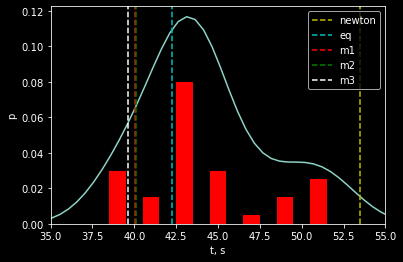

In [18]:
from scipy.stats import gaussian_kde
from scipy.integrate import quad

width = 2
win = np.arange(5, 155, width)
y = []
for x in win:
    mask = ((time < x+width/2) & (time > (x - width/2)))
    y.append(np.sum(mask)/ num_of_alghs/5)
    
plt.bar(win, y, width=width*0.5, color = 'r')
bw = 1/(1.06*sq_cov)*num_of_alghs**(1/5)
filt = time > 0
kernel = gaussian_kde(time[filt], bw_method=bw)

plt.plot(np.linspace(30, 80, 100), kernel(np.linspace(30, 80, 100)))
plt.xlim((35, 55))
plt.axvline(t_new, label='newton', linestyle ='--', color='y')
plt.axvline(results1['t_eq'], label='eq', linestyle ='--', color='c')
plt.axvline(results1['t_m1'], label='m1', linestyle ='--', color ='r')
plt.axvline(results1['t_m2'], label='m2', linestyle ='--', color ='g')
plt.axvline(results1['t_m3'], label='m3', linestyle ='--', color ='w')
plt.xlabel('t, s')
plt.ylabel('p')
plt.legend()
plt.savefig('./data/Prob1,4_dist', dpi = 400)
plt.show()

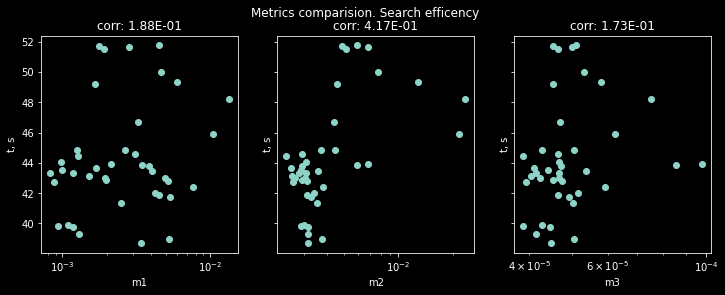

In [19]:
filt = np.logical_and(time > 0, time < 90)
m1_list = []
m2_list = []
m3_list = []

# Matrix of Weights
# Matrix of Weights
M = 5
A1 = np.zeros((Nx, Nx))
A3 = np.zeros((Nx, Nx))
du = 1e-2
for i in range(M):
    step = Nt//M
    Jf = partion.precompute_Jf(solver_cl, X_cl[:, i*step], Nx)
    Jf_n = partion.precompute_Jf(solver_cl, X_cl[:, i*step]+du, Nx)
    func = lambda i, j: m1(Jf, i, j)
    B = partion.adj_matrix(func, Nx)
    B /= np.max(B)
    A1 += B
    func = lambda k, m: m3(solver_cl, Jf, Jf_n, k, m)
    B = partion.adj_matrix(func, Nx)
    #B /= np.max(B)
    A3 += B
A1 /= M
A3 /= M
func = lambda i, j: m2(X_cl, i, j)
A2 = partion.adj_matrix(func, Nx)

func1 = lambda borders: partion.metrics1(borders, A1)
func2 = lambda borders: partion.metrics2(borders, A2)
func3 = lambda borders: partion.metrics2(borders, A3)
for domain in borders[:, filt].T:
    part = np.concatenate(([0], domain, [Nx]), axis = 0)
    m1_list.append(func1(part))
    m2_list.append(func2(part))
    m3_list.append(func3(part))

m1_arr = np.array(m1_list)
m2_arr = np.array(m2_list)
m3_arr = np.array(m3_list)

cov_m1 = np.cov(np.stack((time[filt], m1_arr) , axis = 0))

cov_m2 = np.cov(np.stack((time[filt], m2_arr) , axis = 0))

cov_m3 = np.cov(np.stack((time[filt], m3_arr) , axis = 0))

fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
fig.suptitle('Metrics comparision. Search efficency')
axs[0].scatter(m1_arr, time[filt])
#plt.legend()
axs[0].set_xscale('log')
axs[0].set_title('corr: {:.2E}'.format(cov_m1[1, 0]/np.sqrt(cov_m1[0, 0]*cov_m1[1, 1])))
axs[0].set_xlabel('m1')
axs[0].set_ylabel('t, s')
#plt.legend()
axs[1].scatter(m2_arr, time[filt])
axs[1].set_xscale('log')
axs[1].set_title('corr: {:.2E}'.format(cov_m2[1, 0]/np.sqrt(cov_m2[0, 0]*cov_m2[1, 1])))
axs[1].set_xlabel('m2')
axs[1].set_ylabel('t, s')
#plt.legend()
axs[2].scatter(m3_arr, time[filt])
axs[2].set_xscale('log')
axs[2].set_title('corr: {:.2E}'.format(cov_m3[1, 0]/np.sqrt(cov_m3[0, 0]*cov_m3[1, 1])))
axs[2].set_xlabel('m3')
axs[2].set_ylabel('t, s')
plt.savefig('./data/Prob1,4_corr', dpi = 400)
plt.show()

Исследуем задачу на оптимальное число доменов

In [20]:
mean_time = np.zeros((30, 4))
var = np.zeros((30, 4))

param = {
        'Nx': Nx, 
        'Nt': Nt
}

for k in range(3, 30):
    Nd = k
    borders1 = partion.domain_builder2(A1, Nd, inv = False, k = Nd)
    borders2 = partion.domain_builder2(A2, Nd, inv = True, k = Nd)
    borders3 = partion.domain_builder2(A3, Nd, inv = False, k = Nd)
    borders4 = partion.partion_equally(Nx, Nd)

    for bd, i in zip([borders1, borders2, borders3, borders4], [0, 1, 2, 3]):
        nl_solver = aspen(Nd, bd, 1e-2, crit_abs = 1e-3)
        solver_as = one_phase(param, D, nl_solver)
        solver_as.x0 = np.copy(x0)
        solver_as.setBoundary(bd1, bd2)
        t = np.zeros(5)
        for j in range(5):
            _, _, mes, t[j] = wrapper.test(solver_as, sample_size = 1)
            
        var[k, i] = np.var(t)
        mean_time[k, i] = np.mean(t)
    
        if mes != 'OK':
            print(k, i, 'did not converged')

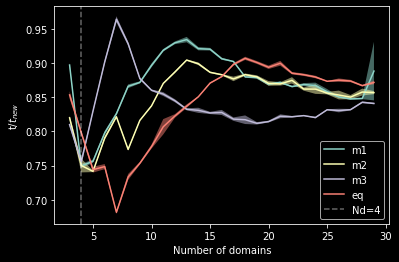

In [22]:
# 3, -2
end = 30
for name, i in zip(['m1', 'm2', 'm3', 'eq'], [0, 1, 2, 3]):
    plt.plot(np.arange(3, end), mean_time[3:end, i]/t_new, label=name)
    plt.xlabel('Number of domains')
    plt.ylabel('t/$t_{new}$')
    tmp = np.sqrt(var[3:end, i])/t_new
    plt.fill_between(np.arange(3, end), mean_time[3:end, i]/t_new-tmp, 
                     mean_time[3:end, i]/t_new+tmp, alpha=0.5)
plt.axvline(4, linestyle='--', label='Nd=4', alpha=0.4)
plt.legend()
plt.savefig('./data/cmp222', dpi = 400)
plt.show()

In [123]:
w1, _ = partion.spec_bis(A1, inv = False, k = 17)
w2, _ = partion.spec_bis(A2, inv = True, k = 17)
w3, _ = partion.spec_bis(A3, inv = False, k = 17)

2.0152367527319686


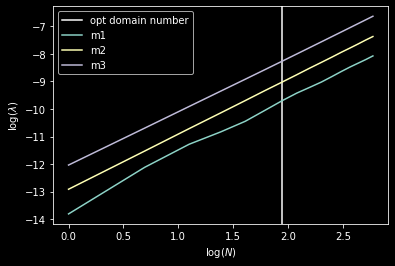

In [127]:
def linear(x, a, b):
    return x*a+b
from scipy.optimize import curve_fit

x = np.arange(1, 17)
plt.axvline(np.log(7), label='opt domain number')
plt.xlabel('$\log(N)$')
plt.ylabel('$\log(\lambda)$')
plt.plot(np.log(x), np.log(w1[1:]), label='m1')
plt.plot(np.log(x), np.log(w2[1:]), label='m2')
plt.plot(np.log(x), np.log(w3[1:]), label='m3')
plt.legend()
popt, pcov = curve_fit(linear, np.log(x), np.log(w1[1:]))
print(popt[0])
plt.show()

In [23]:
aspen_time = np.zeros(10)
aspen_iters = np.zeros(10)
local_iters = np.zeros((10, 7))
Nd = 7
borders = partion.partion_equally(Nx, Nd)
for i in range(10):
    Nt = 50*(1+i)
    param = {
        'Nx': Nx, 
        'Nt': Nt,
    }
    nl_solver = aspen(7, borders, 1e-2, max_lc = 14, crit_abs = 1e-3)
    solver_as = one_phase(param, D, nl_solver)
    solver_as.x0 = np.copy(x0)
    solver_as.setBoundary(bd1, bd2)
    _, _, message, t = wrapper.test(solver_as, sample_size = 3)
    
    aspen_time[i] = t
    aspen_iters[i] = np.sum(solver_as.timelog.aspen_iters)/Nt
    local_iters[i, :] = solver_as.timelog.domain_iters
    if message != 'OK':
        print(i, 'not converged')

In [33]:
newton_time = np.zeros(10)
newton_iters = np.zeros(10)

for i in range(10):
    Nt = 50*(1+i)
    param = {
        'Nx': Nx, 
        'Nt': Nt,
    }
    nl_solver = newton(1e-2, kmax = 14, crit_abs = 1e-3)
    solver = one_phase(param, D, nl_solver)
    solver.x0 = np.copy(x0)
    solver.setBoundary(bd1, bd2)
    _, _, message, t = wrapper.test(solver, sample_size = 3)
    
    newton_time[i] = t
    newton_iters[i] = np.sum(solver.timelog.kn)/Nt
    if message != 'OK':
        print(i, 'not converged')

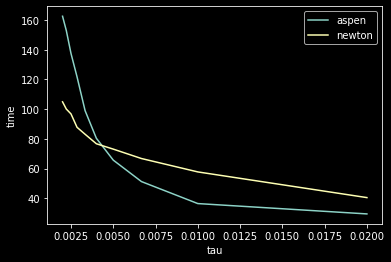

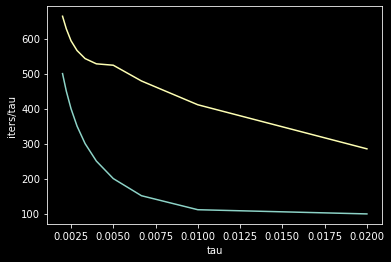

In [37]:
tau = 1/(50*np.arange(1, 11))
plt.plot(tau, aspen_time, label='aspen')
plt.plot(tau, newton_time, label='newton')
plt.ylabel('time')
plt.xlabel('tau')
plt.legend()
plt.show()

plt.plot(tau, aspen_iters/tau, label='aspen')
plt.plot(tau, newton_iters/tau, label='newton')
plt.ylabel('iters/tau')
plt.xlabel('tau')
plt.show()

### Задача 2

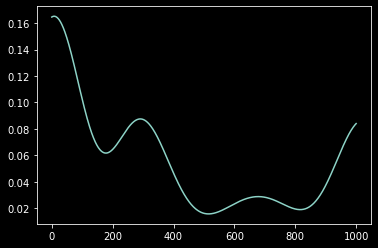

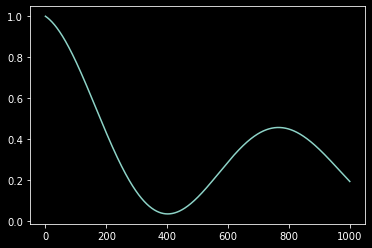

In [196]:
plt.style.use('dark_background')
# inital condition
Nx = 1000
Nt = 100
D = Diffusion(Nx, 0.9, 1, 0.5e-1, model=model)
x = np.linspace(0, 1, Nx+1)
val = 0.5e-1*np.ones(Nx+1)
val *= (1+0.2*np.cos(2*np.pi*x))
val *= (1+0.4*np.cos(3*np.pi/2*x))
val *= (1+0.4*np.cos(6*np.pi*x))
val *= (1+0.3*np.sin(np.pi*x))
val *= (1+0.4*np.cos(3*np.pi/2*x))
plt.plot(val)
plt.show()
x = np.linspace(0, 1, Nx)

x0 = np.exp(-x)*(1+0.9*np.cos(5*np.pi/2*x))

x0 /= np.max(x0)
x0 = np.reshape(x0, (-1, 1))
bd1 = x0[0]
bd2 = x0[-1]
plt.plot(x0)
plt.show()

setSources = lambda x: x.setSources([0.2, 0.8], [4,-25])

test started
verdict : OK
mean time : 93.04598498344421
mean newton iterations:  6.61


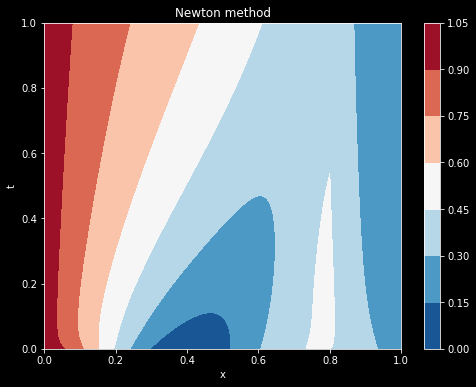

In [197]:
results2 = {}
param = {
    'Nx': Nx, 
    'Nt': Nt,
}
nl_solver = newton(1e-3, kmax = 14, crit_abs = 1e-4)
solver_cl = one_phase(param, D, nl_solver)
solver_cl.x0 = np.copy(x0)
solver_cl.setBoundary(bd1, bd2)
setSources(solver_cl)
X_cl, message, t = test(solver_cl, sample_size = 1)

results2['t_new'] = np.copy(t)

wrapper.show_res(solver_cl)

test started
verdict : OK
mean time : 96.82065391540527
mean aspen iterations:  2.0
iters : [15.36  2.09  1.95  1.65  1.15]


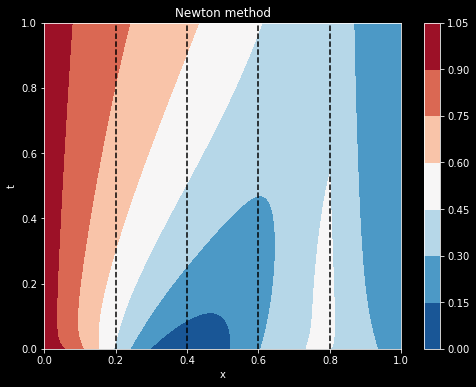

--time comparision--
newton : 92.98424172401428
aspen : 96.55322909355164


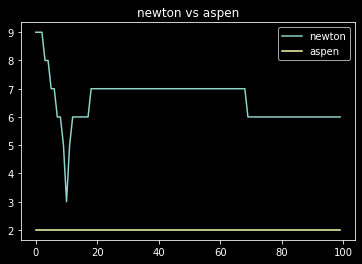

In [198]:
Nd = 5
borders = partion.partion_equally(Nx, Nd)

param = {
    'Nx': Nx, 
    'Nt': Nt
}
nl_solver = aspen(Nd, borders, 1e-3, crit_abs = 1e-4)
solver_as = one_phase(param, D, nl_solver)
solver_as.x0 = np.copy(x0)
solver_as.setBoundary(bd1, bd2)
setSources(solver_as)
X, message, t = test(solver_as, sample_size = 1)
results2['t_eq'] = np.copy(t)
wrapper.show_res(solver_as)
wrapper.compare([solver_cl, solver_as], ['newton', 'aspen'])

In [ ]:
import torch

def border_changer(solver, X, Nd):
    Jf = partion.precompute_Jf(solver, X[:, -1], Nx)
    Jf_n = partion.precompute_Jf(solver, X[:, -1]+1e-2, Nx)
    func1 = lambda k, m: m3(solver, Jf, Jf_n, k, m)
    #func1 = lambda k, m: m1(Jf, k, m)
    A3 = partion.adj_matrix(func1, Nx)
    borders = partion.domain_builder2(A3, Nd,
        inv = False, k =Nd)
    return borders
    
Nd = 5
borders = partion.partion_equally(Nx, Nd)
param = {
    'Nx': Nx, 
    'Nt': Nt
}
nl_solver = aspen(Nd, borders, 1e-3, crit_abs = 1e-4)
solver_as = one_phase(param, D, nl_solver, bd_ch = border_changer)
solver_as.x0 = np.copy(x0)
setSources(solver_as)
solver_as.setBoundary(bd1, bd2)
X, message, t = test(solver_as, sample_size = 1)
results2['t_m1'] = np.copy(t)

test started


In [ ]:
wrapper.show_res(solver_as)
wrapper.compare([solver_cl, solver_as], ['newton', 'aspen'])